In [4]:

import os
import sys
raw_data_dir = ''
acc_key = 'acc'
plot_examples = False # notebook file size will increase by between 30 and 60MB if set to True; <1MB otherwise

if  'COLAB_GPU' in os.environ :
    acc_key = 'accuracy'
    print('Using Google Colab. Setting up environment')
    raw_data_dir = '/content/drive/My Drive/Colab Notebooks/' 
    #raw_data_dir = 'Raw/'

    !pip install mne==0.19.2
    !pip install pyedflib==0.1.15
    !pip install chart_studio==1.0.0


    print('\n \n To load files from Google Drive, account validation is required.')
    #mount to drive -- files should be located in the /Colab Notebooks directory
    from google.colab import drive
    drive.mount("/content/drive", force_remount=True)
    
    if not os.path.exists('/content/tmp/eeg_sz/ReadData'):
        os.makedirs('/content/tmp/eeg_sz/ReadData')
        os.makedirs('/content/tmp/eeg_sz/utils')
    # download project utilities and data reader 
    !curl -u MTynes:08ec0e86b785be94d2cefc791029008c7155da8b https://raw.githubusercontent.com/WinAIML/schizophrenia/master/ReadData/RawDataReader.py > /content/tmp/eeg_sz/ReadData/RawDataReader.py
    !curl -u MTynes:08ec0e86b785be94d2cefc791029008c7155da8b https://raw.githubusercontent.com/WinAIML/schizophrenia/master/MLModels/utils/ModelBuilder.py > /content/tmp/eeg_sz/utils/ModelBuilder.py
    !curl -u MTynes:08ec0e86b785be94d2cefc791029008c7155da8b https://raw.githubusercontent.com/WinAIML/schizophrenia/master/MLModels/utils/ChartBuilder.py > /content/tmp/eeg_sz/utils/ChartBuilder.py
    sys.path.append('/content/tmp/eeg_sz/')
    
elif 'KAGGLE_URL_BASE' in os.environ:
    acc_key = 'accuracy'
    print('Using Kaggle kernel. Setting up environment')
    !pip install update mne==0.19.2
    !pip install pyedflib==0.1.15
    !pip install chart_studio
    !svn checkout https://github.com/WinAIML/schizophrenia/trunk/Data/Raw
    raw_data_dir = 'Raw/'
    
    if not os.path.exists('/kaggle/working/eeg_sz/ReadData'):
        os.makedirs('/kaggle/working/eeg_sz/ReadData')
        os.makedirs('/kaggle/working/eeg_sz/utils')
        # download project utilities and data reader 
    !curl -u MTynes:08ec0e86b785be94d2cefc791029008c7155da8b https://raw.githubusercontent.com/WinAIML/schizophrenia/master/ReadData/RawDataReader.py > /kaggle/working/eeg_sz/ReadData/RawDataReader.py
    !curl -u MTynes:08ec0e86b785be94d2cefc791029008c7155da8b https://raw.githubusercontent.com/WinAIML/schizophrenia/master/MLModels/utils/ModelBuilder.py > /kaggle/working/eeg_sz/utils/ModelBuilder.py
    !curl -u MTynes:08ec0e86b785be94d2cefc791029008c7155da8b https://raw.githubusercontent.com/WinAIML/schizophrenia/master/MLModels/utils/ChartBuilder.py > /kaggle/working/eeg_sz/utils/ChartBuilder.py
    #!wget -O/content/tmp/eeg_sz/utils/ChartBuilder.py -P/utils https://raw.githubusercontent.com/WinAIML/schizophrenia/master/MLModels/utils/ChartBuilder.py

    sys.path.append('/kaggle/working/eeg_sz/')

    # Dataset needs to be manually added to the current session. Find the directory name using
    # print(os.listdir("../input"))

    # Then set the data directory
    raw_data_dir = '../input/eeg-in-schizophrenia/Raw/'

        
else: 
    # assuming that a local run will be launched only from a github project; 
    # add the utils and ReadData directories to the temporary path
    if 'HOMEPATH' in os.environ:
        print('Using homepath ' + os.environ['HOMEPATH'])
    raw_data_dir = '../../Data/Raw/'
    
    from pathlib import Path
    import sys
    sys.path.append(os.path.realpath('..'))
    path = Path(os.getcwd())
    sys.path.append(str(path.parent.parent))


import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, Conv1D, MaxPooling2D, AveragePooling2D, AveragePooling1D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm

import pandas as pd
import numpy as np
import random 

from importlib import reload  #reload(chart_builder)


#################
# import project utilities and the raw data reader
# Kaggle environment does not accept 'utils' as a file, so it must be accessed seperately

import ReadData.RawDataReader as data_reader
import utils.ModelBuilder as model_builder
import utils.ChartBuilder as chart_builder


Using Google Colab. Setting up environment

 
 To load files from Google Drive, account validation is required.
Mounted at /content/drive
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14735  100 14735    0     0   141k      0 --:--:-- --:--:-- --:--:--  142k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6767  100  6767    0     0   104k      0 --:--:-- --:--:-- --:--:--  104k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  9996  100  9996    0     0   154k      0 --:--:-- --:--:-- --:--:--  154k


In [17]:
#!curl -u MTynes:08ec0e86b785be94d2cefc791029008c7155da8b https://raw.githubusercontent.com/WinAIML/schizophrenia/master/ReadData/RawDataReader.py > /content/tmp/eeg_sz/ReadData/RawDataReader.py
#reload(data_reader)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14822  100 14822    0     0  66765      0 --:--:-- --:--:-- --:--:-- 66765


In [55]:
#raw_data_dir = '../input/eeg-in-schizophrenia/Raw/'
ignore_list = [] #['s12', 's14']  # List of patient files that should be skipped
resolution_hz = 250  # Hz resolution - number of frames per second; 250Hz is the selected value for the EEG dataset
time_window = resolution_hz * 20 # Seconds of data to include in one slice;

all_channels = ['Fp2', 'F8', 'T4', 'T6', 'O2', 'Fp1', 'F7', 'T3', 'T5', 'O1', 'F4',
                'C4', 'P4', 'F3', 'C3', 'P3', 'Fz', 'Cz', 'Pz']
excluded_channels = [ 'T3', 'T5', 'T6', 'O1', 'F3', 'Fp1', 'Fp2', 'P4', 'F8']
excluded_channels =  ['Fp2', 'F8', 'T4', 'T6', 'O2', 'Fp1', 'F7', 'T3', 'T5', 'O1', 'F4',
                'C4', 'F3', 'C3', 'Fz', 'Cz']
#excluded_channels = []

chans = len(all_channels) - len(excluded_channels)
data = data_reader.get_raw_data(raw_data_dir, resolution_hz, ignore_list, 
                                excluded_channels, time_window, remove_outliers=False)
#np.save('data', data)

Minimum EEG reading duration:  740  seconds
Maximum EEG reading duration:  2170  seconds
Median EEG reading duration:  925.0 seconds


'Shape of raw data for healthy controls: '

(14, 125001, 3)

'Shape of raw data for schizophrenic patients: '

(14, 125001, 3)

Selecting training  / testing / validation sets randomly from patient data
Splitting data into time windows to improve stability of results
(10, 125001, 3)
(250, 5000, 3)
Shape of X_train:  (500, 5000, 3)
Shape of X_validate:  (100, 5000, 3)
Shape of X_test:  (100, 5000, 3)
Selected indexes for control group: 
Training:  [4, 7, 13, 2, 9, 6, 3, 1, 0, 5]
Testing:  [11, 10]
Validation:  [8, 12]

Selected indexes for patient group: 
Training:  [9, 5, 1, 7, 10, 0, 3, 4, 12, 13]
Testing:  [2, 8]
Validation:  [11, 6]


In [0]:
if plot_examples:
    random_selection =  data_reader.get_random_participants(raw_data_dir, data, ignore_list, resolution_hz)
    chart_builder.plot_random_participants(data, ignore_list, excluded_channels, all_channels, random_selection)


In [0]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Embedding
#from keras.regularizers import l2
from tensorflow.keras import regularizers

# adapted from https://github.com/vlawhern/arl-eegmodels/blob/master/EEGModels.py
def CNN(time_steps, nb_features, chans, nb_classes=2, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    
    if dropoutType == 'SpatialDropout1D':
        dropoutType = SpatialDropout1D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout1D '
                         'or Dropout, passed as a string.')
    print('dropout rate: ', dropoutRate)
    input1   = Input(shape = (time_steps, chans))
    
    pooling_layer1_format = 'channels_first'
    pooling_layer2_format = 'channels_last'
   

    ##################################################################
    block1       = Conv1D(4, (2), padding = 'same',
                          activity_regularizer=regularizers.l2(0.01),
                                  # input_shape = ( chans, samples),
                                   use_bias = False)(input1)
    block1       = BatchNormalization(axis = -1)(block1)
    block1       = Activation('elu')(block1)
    block1       = Conv1D(9, (4), padding='same',
                          activity_regularizer=regularizers.l2(0.01),
                          use_bias = False )(block1)
    block1       = BatchNormalization(axis = -1)(block1)
    block1       = Activation('elu')(block1)
    #block1       = AveragePooling1D(pool_size=(4),  name='apl1')(block1)
    block2       = dropoutType(dropoutRate)(block1)
    
    """ 
    block2       = Conv1D(5, ( 16),
                          activity_regularizer=regularizers.l2(0.01),
                          use_bias = False, padding = 'same' )(block2)
    block2       = BatchNormalization(axis = -1)(block2)
    block2       = Activation('elu')(block2)
    block2       = dropoutType(dropoutRate)(block2)"""
    
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)

In [0]:


import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.optimizers
from tensorflow.keras import backend as K
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# Create the /tmp directory if it doesn't already exist
import os
if not os.path.exists('tmp'):
    os.makedirs('tmp')


def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred -y_true)))


# Construct a learning rate scheduler such that the lr is decreased when the loss remains unchanged after 4 epochs
# Adapted from
# https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1
class LossHistory(tf.keras.callbacks.Callback):
    def __init__(self, minimum_learning_rate):
        self.losses = []
        self.lr = []
        self.last_loss_improvement = None
        self.loss_unchanged_count = 0
        self.minimum_learning_rate = minimum_learning_rate

    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        self.last_loss_improvement = 1.0
        self.loss_unchanged_count = 0

    def on_epoch_end(self, batch, logs={}):
        epoch_loss = logs.get('val_loss')
        # track if losses are being updated
        if (len(self.losses) > 1) and ((epoch_loss == self.losses[-1]) or (epoch_loss > self.last_loss_improvement)):
            self.loss_unchanged_count += 1
        else:
            self.loss_unchanged_count = 0
            self.last_loss_improvement = epoch_loss

        self.losses.append(epoch_loss)

    # Implement the lr_loss_scheduler within the class so that it can access loss_unchanged_count
    def on_epoch_begin(self, batch,
                       logs={}):
        current_lr = K.get_value(self.model.optimizer.lr)
        lr = current_lr - (current_lr / 4)  # propose to decrement lr by 25% of current value
        if self.loss_unchanged_count > 3 and lr >= self.minimum_learning_rate:
            self.loss_unchanged_count = 0  # reset
            K.set_value(self.model.optimizer.lr, lr)  # set for the model
            print('Updated learning rate to ', lr)
            # return K.get_value(self.model.optimizer.lr)


def construct_and_run_model_loo(data, model, optimizer, checkpoint_file_name, epochs=150,
                            batch_size=64, loss_type='categorical_crossentropy',
                            metrics=['accuracy', rmse], minimum_learning_rate=10.e-6):  # 'mse', 'mae', ):
    loss_history = LossHistory(minimum_learning_rate)

    # compile the model and set the optimizers
    model.compile(loss=loss_type, optimizer=optimizer,
                  metrics=metrics)

    model.summary()

    # count number of parameters in the model
    numParams = model.count_params()

    # set a valid path for your system to record model checkpoints
    checkpointer = ModelCheckpoint(filepath=checkpoint_file_name, verbose=1,
                                   save_best_only=True)

    # change_lr = tensorflow.keras.callbacks.LearningRateScheduler(lr_loss_scheduler)
    print('MB::   Shape of X_train: ', np.asarray(data['X_train']).shape)
    print('MB::   Shape of X_validate: ', np.asarray(data['X_validate']).shape)
    print('MB::   Shape of X_test: ', np.asarray(data['X_test']).shape)
    history = model.fit(data['X_train'], data['Y_train'], batch_size=batch_size, epochs=epochs,
                             verbose=2,
                             callbacks=[checkpointer, loss_history])

    model.load_weights(checkpoint_file_name)

    probs = model.predict(data['X_test'])
    preds = probs.argmax(axis=-1)
    acc = np.mean(preds == data['Y_test'].argmax(axis=-1))
    print("Classification accuracy: %f " % acc)
    return model, acc, history




In [56]:
import sklearn.decomposition as decomposition

def select_denoised_data(patient_data):
    all_features = []
    
    for entry in patient_data:
        pca_denoise = decomposition.PCA(n_components=np.asarray(patient_data).shape[2])
        pca_denoise.fit(entry.transpose())
        denoised_data = pca_denoise.components_#[:14] #select top v components, where v is based on chart of explained variance
        all_features.append(np.asarray(denoised_data).transpose()) 

    return all_features
    
print('shapes of hc_data and sz_data: ')
print(np.asarray(data['hc_data']).shape)
print(np.asarray(data['sz_data']).shape)
#hcd = np.concatenate([select_denoised_data(data['hc_data']), data['hc_data']], axis=2)
#szd = np.concatenate([select_denoised_data(data['sz_data']), data['sz_data']], axis=2)

#hcd = select_denoised_data(data['hc_data'])
#szd = select_denoised_data(data['sz_data'])
#print('shape of hcd: ', np.asarray(hcd).shape)
#all_data = np.concatenate([np.asarray(hcd), np.asarray(szd)], axis=0)


all_data = np.concatenate([data['hc_data'], data['sz_data']], axis=0)
print('Shape of all data: ', np.asarray(all_data).shape)
all_labels = [0] * len(data['hc_data']) + [1] * len(data['sz_data'])
all_labels = np_utils.to_categorical(all_labels, num_classes=2)
print('label 0 and -1 : ' )


print(all_labels[0])
print(all_labels[-1])

shapes of hc_data and sz_data: 
(14, 125001, 3)
(14, 125001, 3)
Shape of all data:  (28, 125001, 3)
label 0 and -1 : 
[1. 0.]
[0. 1.]


In [0]:
##print(hcd[0][0])
##print(szd[0][0])

In [68]:
%%time
#reload(model_builder)
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
import random, string


    

from ReadData.RawDataReader import *

def smooth_data(x_train, x_validate, x_test):
    # Estimate mean and standard deviation

    # use the training data to fit the scaler, as suggested here https://stackoverflow.com/a/50567308
    # flatten the features then reintroduce the 3rd dimension
    dataset_flattened = flatten_features(x_train)
    means = column_means(dataset_flattened)
    stdevs = column_stdevs(dataset_flattened, means)
    
    x_train_shape = np.asarray(x_train).shape
    x_validate_shape = np.asarray(x_validate).shape
    x_test_shape = np.asarray(x_test).shape
    # set outliers to median values for each channel
    print('Removing outliers by channel')
    x_train = standardize_dataset(flatten_features(x_train),means, stdevs)
    x_train = x_train.reshape(x_train_shape)
    x_validate = standardize_dataset(flatten_features(x_validate), means, stdevs)  # use means and stdevs from training
    x_validate = x_validate.reshape(x_validate_shape)
    x_test = standardize_dataset(flatten_features(x_test), means, stdevs)
    x_test = x_test.reshape(x_test_shape)
    return x_train, x_validate, x_test

# from https://stackoverflow.com/questions/2030053/random-strings-in-python
def random_string(length):
   letters = string.ascii_lowercase
   return ''.join(random.choice(letters) for i in range(length))

def leave_one_out(data, all_data, all_labels, model, time_window, checkpoint_file_path, chans, 
                  optimizer='Adam', remove_outliers=False):
    #model.summary()

    model_list, test_acc_list, history_list = [], [], []
    offset = 0 #16 #len(data['hc_data'] + 3)#limit to participants with the worse scores

    for i, subject_data in enumerate(all_data[offset:]): 
        print('\n\nBeginning training for subject ', str(i))
        x_test =  np.array([subject_data])
        y_test = np.array([all_labels[offset :][i]])
        print('shape of x_test: ', np.asarray(x_test).shape)

        
        # get all other data
        ###train_val_data =  np.setdiff1d(all_data,x_validate)
        ###train_val_data = train_val_data.reshape(all_data.shape[0] - 1, all_data.shape[1], all_data.shape[2]) #26, 125001, 19)
        print('shape of all data originally: ', np.asarray(all_data).shape)
        train_val_data = np.delete(all_data.copy(), i + offset, axis=0)
        print('shape of train_val_data after removing subject i: ', np.asarray(train_val_data).shape)
        train_val_labels =  np.delete(all_labels.copy(), i + offset, axis=0)
        
        # split the data for this iteration into the hc and sz groups
        # to provide more equal distribution for the train and validation sets
        len_hc = len(data['hc_data']) 
        len_iter_hc = len_hc - 1 if i <= len_hc -1 else len_hc
        print('i: {}, length of hc for this iteration: {}'.format(i, len_iter_hc))
        hc_iter_data = train_val_data[:len_iter_hc]
        hc_iter_labels = train_val_labels[:len_iter_hc]
        sz_iter_data = train_val_data[len_iter_hc:]
        sz_iter_labels = train_val_labels[len_iter_hc:]

        # determine training and validation sets
        #x_train, x_validate, y_train, y_validate = \
        #        train_test_split(train_val_data, train_val_labels, test_size=0.2, random_state=1)
        hc_x_train, hc_x_validate, hc_y_train, hc_y_validate = \
                train_test_split(hc_iter_data, hc_iter_labels, test_size=0.1, random_state=1)
        sz_x_train, sz_x_validate, sz_y_train, sz_y_validate = \
                train_test_split(sz_iter_data, sz_iter_labels, test_size=0.1, random_state=1)
        x_train = np.concatenate([hc_x_train, sz_x_train], axis=0)
        y_train = np.concatenate([hc_y_train, sz_y_train], axis=0)
        x_validate = np.concatenate([hc_x_validate, sz_x_validate], axis=0)
        y_validate = np.concatenate([hc_y_validate, sz_y_validate], axis=0)

        # remove outliers
        if remove_outliers:
          print('Removing outliers')
          x_train, x_validate, x_test = smooth_data(x_train, x_validate, x_test)
          print('Shape of x_train: ', np.asarray(x_train).shape)
          
        print('shape of x_train after removal of target: ', np.asarray(x_train).shape)
        # apply time window
        x_train = chunk_list(np.asarray(x_train), time_window)
        x_validate = chunk_list(x_validate, time_window)
        x_test = chunk_list(x_test, time_window)
        
        print('shape of x_train: ', np.asarray(x_train).shape)
        print('shape of x_validate: ', np.asarray(x_validate).shape)
        print('shape of x_test: ', np.asarray(x_test).shape)
        # Update labels - copy the label for each time window of the sample
        #print('y test before split update: ')
        #print(y_test)
        y_train = [l for l in y_train for _ in np.arange(len(x_test))]
        y_validate = [l for l in y_validate for _ in np.arange(len(x_test))]
        y_test = [l for l in y_test for _ in np.arange(len(x_test))]
        #print('y_test after split update: ')
        #print(y_test)
        
        # update the values in the data dictionary
        data['X_train'] = np.array(x_train) #np.asarray(x_train)#.reshape(500, 5000, 19)
        data['Y_train'] = np.array(y_train)
        data['X_validate'] = np.array(x_validate) #x_validate#.reshape(150, 5000, 19)
        data['Y_validate'] = np.array(y_validate)
        data['X_test'] = np.array(x_test) #.reshape(25, 5000, 19)
        data['Y_test'] = np.array(y_test)
                    
        filepath = checkpoint_file_path + str(i) + random_string(10) + '.h5'

        #checkpoint = ModelCheckpoint(filepath, #monitor='val_acc', 
        #                             verbose=0, save_best_only=True, save_weights_only=True, mode='auto',period=1)
        #initialize and ensure that model is reset
        """mdl = tf.keras.models.clone_model(model) 
        mdl.load_weights(empty_weights_file)
        K.get_session().close()
        K.set_session(tf.Session())
        K.get_session().run(tf.global_variables_initializer())
        """
        mdl = CNN(time_steps=time_window, chans=chans, nb_features=1, nb_classes=2 )

        
        completed_model, test_acc, history = model_builder.construct_and_run_model_loo(data, mdl, optimizer, filepath, 
                                                        epochs=50, batch_size=32, loss_type='cosine_similarity')
        
        #tf.reset_default_graph()  
        reload(tf)
        reload(K)
        #reload(Checkpoint)
        #sess = tf.s.Session(config=tf.ConfigProto()) 
        #sess.close()
        #tf.global_variables_initializer().run() 
        #history = model_builder.construct_and_run_model(model, )
        model_list.append(completed_model)
        test_acc_list.append(test_acc)
        history_list.append(history)
    return model_list, test_acc_list, history_list
        
# def plot_loo(history_list)     


### CNN

# Declare model, optimizer and checkpoint file
model = CNN(time_steps=time_window, chans=chans*2, nb_features=1, nb_classes=2 )
cnn_opt_adam = tf.keras.optimizers.Adam(lr=0.00002,  #0.00002, 
                                beta_1=0.95,
                                beta_2=0.92,
                                epsilon=1e-07)
cnn_checkpoint = '/tmp/CNN_checkpoint'


model_list, test_acc_list, history_list = leave_one_out(data, all_data, all_labels, model, 
                                                        time_window, cnn_checkpoint, chans=chans, optimizer=cnn_opt_adam)


Streaming output truncated to the last 5000 lines.
Epoch 32/50

Epoch 00032: val_loss improved from 2051.89502 to 2045.87817, saving model to /tmp/CNN_checkpoint7poxcbsyzlb.h5
18/18 - 0s - loss: 5339.8037 - accuracy: 1.0000 - rmse: 0.1162 - val_loss: 2045.8782 - val_accuracy: 0.6500 - val_rmse: 0.4207
Epoch 33/50

Epoch 00033: val_loss improved from 2045.87817 to 2039.92737, saving model to /tmp/CNN_checkpoint7poxcbsyzlb.h5
18/18 - 0s - loss: 5324.7148 - accuracy: 1.0000 - rmse: 0.1118 - val_loss: 2039.9274 - val_accuracy: 0.6500 - val_rmse: 0.4217
Epoch 34/50

Epoch 00034: val_loss improved from 2039.92737 to 2033.70911, saving model to /tmp/CNN_checkpoint7poxcbsyzlb.h5
18/18 - 0s - loss: 5309.0034 - accuracy: 1.0000 - rmse: 0.1114 - val_loss: 2033.7091 - val_accuracy: 0.6700 - val_rmse: 0.4258
Epoch 35/50

Epoch 00035: val_loss improved from 2033.70911 to 2027.84326, saving model to /tmp/CNN_checkpoint7poxcbsyzlb.h5
18/18 - 0s - loss: 5294.8311 - accuracy: 1.0000 - rmse: 0.1078 - val


Mean test accuracy:  0.59

Test accuracy for individual runs: 
[0.32, 0.56, 0.92, 0.96, 0.72, 0.8, 0.44, 0.92, 0.36, 0.72, 0.8, 0.76, 0.96, 0.68, 0.36, 0.32, 0.36, 0.2, 0.48, 0.24, 0.52, 0.36, 0.72, 0.08, 0.28, 0.8, 0.88, 1.0]


Diagrammed History of Model Metrics


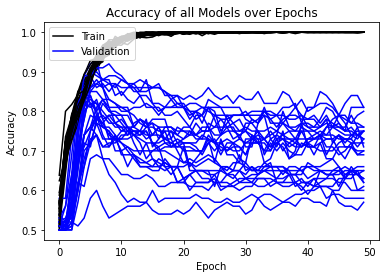

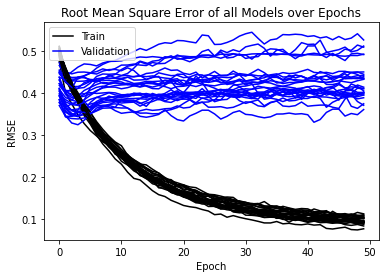

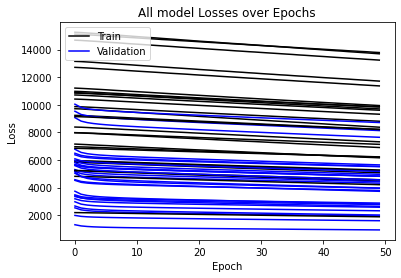

In [69]:
import matplotlib.pyplot as plt

def print_model_metrics_loo(history_list, acc_key):
    print('Diagrammed History of Model Metrics')

    # summarize history for accuracy
    for h in history_list:
        plt.plot(h.history[acc_key], color='black')
        plt.plot(h.history['val_' + acc_key], color='blue')
    plt.title('Accuracy of all Models over Epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # summarize history for RMSE
    for h in history_list:
        plt.plot(h.history['rmse'], color='black')
        plt.plot(h.history['val_rmse'], color='blue')
    plt.title('Root Mean Square Error of all Models over Epochs')
    plt.ylabel('RMSE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # summarize loss history
    for h in history_list:
        plt.plot(h.history['loss'], color='black')
        plt.plot(h.history['val_loss'], color='blue')
    plt.title('All model Losses over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
print('\nMean test accuracy: ', '{0:.2f}'.format(np.mean(test_acc_list)) )
print('\nTest accuracy for individual runs: ')
print(test_acc_list)
print('\n')

print_model_metrics_loo(history_list,     acc_key )

In [0]:
!pip freeze

In [0]:
from platform import python_version

print(python_version())